# Advection equation in 2D - Figure 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from scipy.linalg import expm

In [2]:
# --------------------
# 1) Problem setup
# --------------------
nx, ny = 2**6, 2**6       # Grid points in x and y
#dx, dy = Lx / nx, Ly / ny
ell = 1 #l := L/(N + 1)
Lx, Ly = (nx+1)*ell, (ny+1)*ell    # Domain sizes
dx, dy = ell, ell
#
cx, cy = 1.0, 1.0     # Advection speeds in x, y [v1,v2]=[1,1]

# Time step (somewhat arbitrary here, but must respect a stricter CFL for central diff)
tmax = 20
dt = 0.01
#sigma = 0.1
#dt = sigma * min(dx/abs(cx), dy/abs(cy))
#dt = tmax / nt
nt = int(tmax/dt)  # Number of time steps

# Flatten index mapping: k = i + j*nx
def idx(i, j):
    # Periodic wrap for i,j
    return (i % nx) + (j % ny) * nx

N = nx * ny

# --------------------
# 2) Build central difference operators Dx, Dy (sparse) FDM
# --------------------
# We want: (u[i+1,j] - u[i-1,j]) / (2 * dx)
# and similarly for Dy in y-direction.
# We'll use LIL format for efficient building, then convert to CSR.

Dx = sp.lil_matrix((N, N), dtype=np.float64)
Dy = sp.lil_matrix((N, N), dtype=np.float64)

inv_2dx = 1.0 / (2.0 * dx)
inv_2dy = 1.0 / (2.0 * dy)

for j in range(ny):
    for i in range(nx):
        k = idx(i, j)
        # Central difference in x
        kp1 = idx(i+1, j)
        km1 = idx(i-1, j)
        Dx[k, kp1] = +inv_2dx
        Dx[k, km1] = -inv_2dx
        
        # Central difference in y
        jp1 = idx(i, j+1)
        jm1 = idx(i, j-1)
        Dy[k, jp1] = +inv_2dy
        Dy[k, jm1] = -inv_2dy

Dx = Dx.tocsr()
Dy = Dy.tocsr()
Hmat = (cx * Dx + cy * Dy)

## FDM Finite-Differences

In [3]:
# --------------------
# 3) Build update matrix: B = I - dt ( c_x * Dx + c_y * Dy )
# --------------------
I = sp.eye(N, format='csr')
B = I - dt * Hmat

# --------------------
# 4) Initial condition, flattened
# --------------------
x_vals = np.linspace(0, Lx, nx, endpoint=False)
y_vals = np.linspace(0, Ly, ny, endpoint=False)
X2D, Y2D = np.meshgrid(x_vals, y_vals, indexing='ij')

#u_init_2D = np.exp(-((X2D - 0.5*Lx)**2 + (Y2D - 0.5*Ly)**2)/0.1)
u_init_2D = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        if i>16 and i<32 and j>16 and j<32:
            u_init_2D[i,j] = 1.0
u = u_init_2D.ravel()

# saves
uFDM_dump_1 = np.zeros((nx,ny))
uFDM_dump_2 = np.zeros((nx,ny))
uFDM_dump_3 = np.zeros((nx,ny))

In [4]:
# --------------------
# 5) Time stepping
# --------------------
for n in range(nt):
    if n==0:
        uFDM_dump_1 = u.reshape((nx, ny))
    elif n==int(nt/2):
        uFDM_dump_2 = u.reshape((nx, ny))
    elif n==nt-1:
        uFDM_dump_3 = u.reshape((nx, ny))
    u = B @ u

## Mat-Exp

In [5]:
#1j*Hmat.todense()-(1j*Hmat.todense()).H
HmatDNS = Hmat.todense()
UMXP = expm(-HmatDNS*dt)

# saves
uMXP_dump_1 = np.zeros((nx,ny))
uMXP_dump_2 = np.zeros((nx,ny))
uMXP_dump_3 = np.zeros((nx,ny))

In [6]:
# time-evolve
u = u_init_2D.ravel()
for n in range(nt):
    if n==0:
        uMXP_dump_1 = u.reshape((nx, ny))
    elif n==int(nt/2):
        uMXP_dump_2 = u.reshape((nx, ny))
    elif n==nt-1:
        uMXP_dump_3 = u.reshape((nx, ny))
    u = UMXP @ u

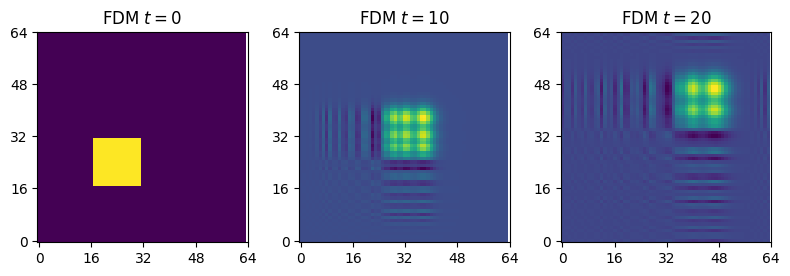

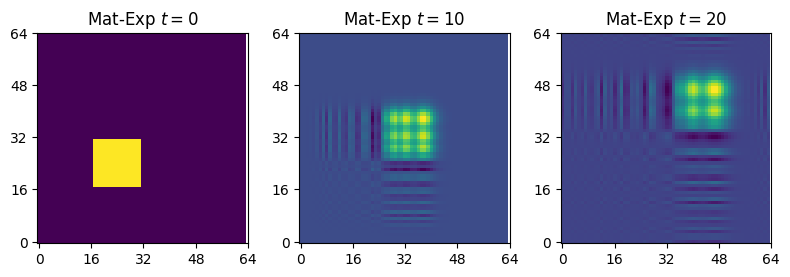

In [7]:
# FDM
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
axes[0].imshow( uFDM_dump_1, origin="lower" )
axes[1].imshow( uFDM_dump_2, origin="lower" )
axes[2].imshow( uFDM_dump_3, origin="lower" )
#cb = plt.colorbar(im, pad=0.05,fraction=0.01)
#cb.ax.yaxis.set_tick_params(labelright=False)
#gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)
#axes = [fig.add_subplot(gs[i]) for i in range(3)]
# Colorbar in the last column
#cax = fig.add_subplot(gs[3])
#cb = plt.colorbar(im, cax=cax, fraction=0.01/2/5)
axes[0].set_title(r'FDM $t=0$')
axes[1].set_title(r'FDM $t=10$')
axes[2].set_title(r'FDM $t=20$')
for i in range(3):
    axes[i].set_xticks([0,16,32,48,64])
    axes[i].set_yticks([0,16,32,48,64])
plt.tight_layout()
plt.show()


# Mat-Exp
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
axes[0].imshow( uMXP_dump_1, origin="lower" )
axes[1].imshow( uMXP_dump_2, origin="lower" )
axes[2].imshow( uMXP_dump_3, origin="lower" )
axes[0].set_title(r'Mat-Exp $t=0$')
axes[1].set_title(r'Mat-Exp $t=10$')
axes[2].set_title(r'Mat-Exp $t=20$')
for i in range(3):
    axes[i].set_xticks([0,16,32,48,64])
    axes[i].set_yticks([0,16,32,48,64])
plt.tight_layout()
plt.show()